In [37]:
"""
通过可视化展示基于二进制哈希码进行图像检索的结果。
具体来说，它从保存的哈希码和标签中加载数据，选择一些查询图像，并展示检索到的最近邻图像以及它们与查询图像的相似性。
"""
from google.colab import drive
drive.mount('/content/drive')

import sys

sys.path.append('/content/drive/MyDrive/DPSH')


import numpy as np
from utils.tools import *
from network import *

import torch
import torch.utils.data as util_data
from torchvision import transforms
import torchvision.datasets as dsets
import torchvision.transforms.functional as F
import torch.optim as optim

from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
def CalcHammingDist(B1, B2):
    q = B2.shape[1]
    distH = 0.5 * (q - np.dot(B1, B2.transpose()))
    return distH

In [39]:
# 从指定目录加载训练集和测试集的二进制哈希码和标签。
# 从图像路径文件中读取训练集和测试集的图像路径。
data_dir = "/content/drive/MyDrive/DPSH/save/CNNF/cifar_48/cifar10-1_48bits_0.8174430544154093/"
trn_binary = np.load(data_dir + "trn_binary.npy")
trn_label = np.load(data_dir + "trn_label.npy")
tst_binary = np.load(data_dir + "tst_binary.npy")
tst_label = np.load(data_dir + "tst_label.npy")


In [40]:
with open("/content/drive/MyDrive/DPSH/data/cifar/database.txt", "r") as f:
    trn_img_path = [int(item) for item in f.readlines()]
with open("/content/drive/MyDrive/DPSH/data/cifar/test.txt", "r") as f:
    tst_img_path = [int(item) for item in f.readlines()]

print(len(trn_img_path))
print(type(trn_img_path))

print(len(tst_img_path))
print(tst_img_path)
print(type(tst_img_path))

56000
<class 'list'>
4000
[14309, 53680, 20891, 18861, 58405, 28305, 43828, 21306, 5154, 14365, 54228, 57139, 11775, 23371, 2824, 59048, 19630, 20454, 38937, 43403, 55703, 30604, 28092, 41677, 48363, 43542, 29819, 19527, 47421, 26913, 57925, 22317, 23964, 41152, 50774, 27533, 18905, 43667, 47740, 42597, 41266, 58935, 42446, 47339, 17015, 199, 17226, 44545, 43427, 32247, 18808, 29378, 3585, 44746, 44975, 59182, 27176, 5484, 38154, 16456, 50422, 9859, 48926, 7784, 52622, 1632, 24791, 36836, 3092, 14754, 2680, 3842, 9604, 7183, 18271, 17917, 14585, 59193, 44116, 906, 6112, 7757, 4477, 56077, 24383, 7520, 9925, 8249, 27048, 35758, 42166, 44930, 58909, 28921, 46990, 21466, 22540, 55302, 10353, 9718, 49420, 3647, 32629, 34781, 7511, 24814, 55452, 52110, 50847, 32734, 46586, 40984, 4155, 56394, 9714, 45089, 43949, 33770, 54667, 812, 51694, 9292, 1338, 1960, 59512, 5457, 24543, 46655, 47805, 27562, 23732, 31286, 49517, 56304, 54854, 1306, 35973, 38433, 11229, 18713, 59590, 49168, 41600, 2413, 

In [41]:
def get_config():
    config = {
        # "alpha": 0.1,
        # "need_PR": False,
        # "optimizer": {"type": optim.SGD, "optim_params": {"lr": 0.005, "weight_decay": 10 ** -5}},
        # "optimizer": {"type": optim.RMSprop, "optim_params": {"lr": 1e-5, "weight_decay": 10 ** -5}},
        # "info": "[DPSH]",
        "resize_size": 256,
        "crop_size": 224,
        "batch_size": 128,
        # "net": AlexNet,
        # "net":ResNet,
        # "dataset": "cifar10",
        "dataset": "cifar10-1",
        # "dataset": "cifar10-2",
        # "dataset": "coco",
        # "dataset": "mirflickr",
        # "dataset": "nuswide_10",
        # "dataset": "nuswide_21",
        # "epoch": 30,
        # "test_map": 5, # 每过 n 轮进行一次验证
        # "save_path": "/content/drive/MyDrive/DPSH/save/Alexnet",
        # "device":torch.device("cpu"),
        # "device": torch.device("cuda:0"),
        # "bit_list": [48],
    }
    # config = config_dataset(config)
    return config

In [42]:
def get_cifar_dataset(config):
    batch_size = config["batch_size"]

    # 1. 设置批量大小和数据集大小

    # # 从 config 中获取批量大小。
    # # 默认情况下，train_size 为 500，test_size 为 100。
    # train_size = 500
    # test_size = 100

    # # 如果数据集是 "cifar10-2"，则 test_size 为 1000。
    # # hwt
    # if config["dataset"] == "cifar10-1":
    #     test_size = 1000
    # # end

    # # 如果数据集是 "cifar10-2"，则 train_size 为 5000，test_size 为 1000。
    # if config["dataset"] == "cifar10-2":
    #     train_size = 5000
    #     test_size = 1000

    # 2. 定义数据预处理步骤
    # 使用 transforms.Compose 组合了一系列的图像预处理步骤，包括调整图像大小、将图像转换为张量、归一化图像等。
    transform = transforms.Compose([
        transforms.Resize(config["crop_size"]),
        transforms.ToTensor(),
        # hwt
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # end
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    cifar_dataset_root = '/content/drive/MyDrive/DPSH/dataset/cifar/'

    # 3.加载数据集
    # 使用自定义的 MyCIFAR10 类加载训练集、测试集和数据库集数据。
    # Dataset
    train_dataset = MyCIFAR10(root=cifar_dataset_root,
                              train=True,
                              transform=transform,
                              download=True)

    test_dataset = MyCIFAR10(root=cifar_dataset_root,
                            train=False,
                             transform=transform)

    CIFAR_dataset = MyCIFAR10(root=cifar_dataset_root,
                              train=False,
                              transform=transform)

    # 4. 合并数据
    # 将训练集和测试集的数据合并，得到完整的数据 X 和标签 L。
    X = np.concatenate((train_dataset.data, test_dataset.data))
    L = np.concatenate((np.array(train_dataset.targets), np.array(test_dataset.targets)))

    # 5. 返回整个CIFAR数据集
    CIFAR_dataset.data = X
    CIFAR_dataset.targets = L

    return CIFAR_dataset

In [43]:
config = get_config()
dataset = get_cifar_dataset(config)
print(len(dataset))
print(type(dataset))
print(dataset[0])

Files already downloaded and verified
60000
<class 'utils.tools.MyCIFAR10'>
(tensor([[[-1.1075, -1.1075, -1.1075,  ...,  0.4166,  0.4166,  0.4166],
         [-1.1075, -1.1075, -1.1075,  ...,  0.4166,  0.4166,  0.4166],
         [-1.1075, -1.1075, -1.1075,  ...,  0.4166,  0.4166,  0.4166],
         ...,
         [ 0.9132,  0.9132,  0.9132,  ..., -0.0116, -0.0116, -0.0116],
         [ 0.9132,  0.9132,  0.9132,  ..., -0.0116, -0.0116, -0.0116],
         [ 0.9132,  0.9132,  0.9132,  ..., -0.0116, -0.0116, -0.0116]],

        [[-0.9503, -0.9503, -0.9503,  ...,  0.1352,  0.1352,  0.1352],
         [-0.9503, -0.9503, -0.9503,  ...,  0.1352,  0.1352,  0.1352],
         [-0.9503, -0.9503, -0.9503,  ...,  0.1352,  0.1352,  0.1352],
         ...,
         [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251],
         [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251],
         [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251]],

        [[-0.7064, -0.7064, -0.7064,  .

In [44]:
# example
index = 3042
image = dataset[index][0]
label = dataset[index][1]
print(image)
print(image.shape)
print(label)

tensor([[[-0.4054, -0.4054, -0.4054,  ..., -0.4568, -0.4568, -0.4568],
         [-0.4054, -0.4054, -0.4054,  ..., -0.4568, -0.4568, -0.4568],
         [-0.4054, -0.4054, -0.4054,  ..., -0.4568, -0.4568, -0.4568],
         ...,
         [ 1.0159,  1.0159,  1.0159,  ..., -1.5185, -1.5185, -1.5185],
         [ 1.0159,  1.0159,  1.0159,  ..., -1.5185, -1.5185, -1.5185],
         [ 1.0159,  1.0159,  1.0159,  ..., -1.5185, -1.5185, -1.5185]],

        [[ 0.3978,  0.3978,  0.3978,  ...,  0.3627,  0.3627,  0.3627],
         [ 0.3978,  0.3978,  0.3978,  ...,  0.3627,  0.3627,  0.3627],
         [ 0.3978,  0.3978,  0.3978,  ...,  0.3627,  0.3627,  0.3627],
         ...,
         [ 1.1506,  1.1506,  1.1506,  ..., -0.7052, -0.7052, -0.7052],
         [ 1.1506,  1.1506,  1.1506,  ..., -0.7052, -0.7052, -0.7052],
         [ 1.1506,  1.1506,  1.1506,  ..., -0.7052, -0.7052, -0.7052]],

        [[ 1.0191,  1.0191,  1.0191,  ...,  0.9842,  0.9842,  0.9842],
         [ 1.0191,  1.0191,  1.0191,  ...,  0

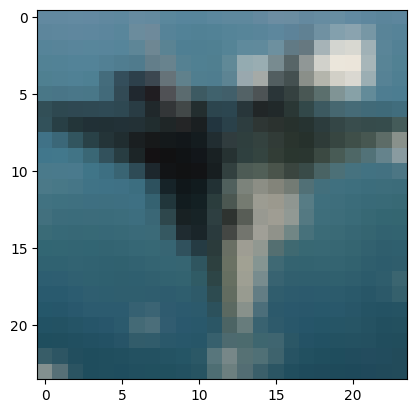

Label: [1 0 0 0 0 0 0 0 0 0]


In [45]:
# 定义逆变换函数
def inverse_transform(img_tensor):
    # 定义归一化的均值和标准差
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # 逆归一化
    img = img_tensor.permute(1, 2, 0).numpy()  # 将通道维度移到最后
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 逆调整大小
    img = F.resize(torch.tensor(img).permute(2, 0, 1), (24, 24))

    return img.permute(1, 2, 0).numpy()  # 转回 HWC 格式

# 定义显示图像的函数
def imshow(img_tensor):
    img = inverse_transform(img_tensor)
    plt.imshow(img)
    plt.show()

# example
index = 3042
dataset[3042]
image = dataset[index][0]
label = dataset[index][1]
imshow(image)
print(f"Label: {label}")

In [46]:
# 设置可视化参数：m 表示查询图像的数量，n 表示每个查询图像的最近邻数量。
# 创建一个画布，并设置图像的大小和分辨率。
# 随机选择 m 个测试样本作为查询图像。
m = 5
n = 8

font_size = 10  # 设置字体大小
plt.figure(figsize=(n * 3, m * 3), dpi=100)  # 调整画布大小和分辨率

tst_select_index = np.random.permutation(range(tst_binary.shape[0]))[0: m]
print(tst_binary.shape[0])
print(tst_select_index)

# 提取对应行的数据
selected_index = []
for i in tst_select_index:
  # print(i)
  index = tst_img_path[i]
  # print(index)
  selected_index.append(index)
# 展示数据
print(selected_index)

4000
[2848 2405 2390 3535  463]
[2022, 24289, 57446, 28841, 56728]


<Figure size 2400x1500 with 0 Axes>

[-1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.] [0 0 0 0 0 0 0 1 0 0]

2022

[24862, 13961, 30803, 44292, 44878, 57478, 20247, 52965]
************************************************************

[ 1.  1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.
  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.
 -1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.] [0 0 0 0 0 0 1 0 0 0]

24289

[49285, 16478, 17583, 36821, 22567, 11647, 34467, 14457]
************************************************************

[-1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.
 -1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.] [0 0 0 0 0 1 0 0 0 0]

57446

[42001, 40536, 6585, 59666, 5588, 35851, 15492, 4479]
*******************************

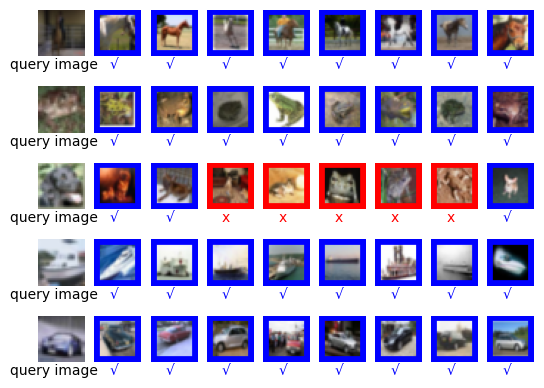

In [47]:
# 可视化查询和检索结果
for row, query_index in enumerate(tst_select_index):

    # 计算查询图像与训练集中所有图像标签的点积，得到 gnd，表示相关性。
    # 计算查询图像与训练集中所有图像的汉明距离。
    # 根据汉明距离排序，取前 n 个最近邻的索引。
    query_binary = tst_binary[query_index]
    query_label = tst_label[query_index]
    print(query_binary,query_label)

    # 计算测试集和检索是否相似
    gnd = (np.dot(query_label, trn_label.transpose()) > 0).astype(np.float32)
    # 通过哈希码计算汉明距离
    hamm = CalcHammingDist(query_binary, trn_binary)
    # 计算最近的n个距离的索引
    ind = np.argsort(hamm)[:n]
    # 返回结果的真值
    t_gnd = gnd[ind]
    # 返回结果的汉明距离
    q_hamm = hamm[ind].astype(int)

    q_img_path = selected_index[row]
    print()
    print(q_img_path)
    print()

    # 提取对应行的数据
    return_img_list = []
    for i in ind:
      # print(i)
      index = trn_img_path[i]
      # print(index)
      return_img_list.append(index)
    # 展示数据
    print(return_img_list)
    print('************************************************************\n')

    # 显示查询图像。
    # 显示检索结果图像，并根据其与查询图像的相关性，标注 √ 或 ×，并用不同颜色框表示相关性。
    plt.subplot(m, n + 1, row * (n+1) + 1)

    img = dataset[q_img_path][0]
    img = inverse_transform(img)
    plt.imshow(img)
    plt.axis('off')
    plt.text(-15, 30, 'query image', fontsize=font_size)

    for index, img_path in enumerate(return_img_list):
        plt.subplot(m, n + 1, row * (n+1) + index + 2)
        img = dataset[img_path][0]
        img = inverse_transform(img)
        # 转换为 PIL 图像
        img = Image.fromarray((img * 255).astype(np.uint8))
        if t_gnd[index]:
            plt.text(10, 40, '√', fontsize=font_size, color='blue')

            img = ImageOps.expand(img, 4, fill=(0, 0, 255))
        else:
            plt.text(10, 40, 'x', fontsize=font_size, color='red')
            img = ImageOps.expand(img, 4, fill=(255, 0, 0))
        plt.axis('off')
        plt.imshow(img)


plt.savefig("/content/drive/MyDrive/DPSH/demo_CIFAR.png")
plt.show()